The goal of this notebook is to do some of the analyses that will go into developing and tuning our tracking pipeline.

In [1]:
# Imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from dotenv import dotenv_values

config = dotenv_values(".env")  

In [2]:
# Produce a histogram of pixel hues, saturations, and values in the video frames after converting them to the HSV color space
# This will allow us to determine the range of hues that correspond to the color of the amphioxus

# Load in sample video for processing
cap = cv.VideoCapture(config['CURRENT_DIR'] + "data/HighSpeedTestClip.mp4")

# Initialize empty list to store hue values with one bin for each possible hue value
hues = np.zeros(180)
saturations = np.zeros(256)
values = np.zeros(256)

# Initialize frame number
frameNum = 0
# Number of frames to process
numFrames = 2

# Loop through each frame in the video
while frameNum < numFrames:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to the HSV color space
    hsv_frame = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    # Extract the hue channel
    hue_channel = hsv_frame[:, :, 0]
    saturation_channel = hsv_frame[:, :, 1]
    value_channel = hsv_frame[:, :, 2]

    # Loop through each pixel in the hue channel and increment the corresponding bin in the hue_values list
    for row in hue_channel:
        for hue in row:
            hues[hue] += 1
    
    for row in saturation_channel:
        for saturation in row:
            saturations[saturation] += 1
    
    for row in value_channel:
        for value in row:
            values[value] += 1
    
    print("Frame number: ", frameNum)
    frameNum += 1

# Normalize the histogram values
hues = hues / np.sum(hues)
saturations = saturations / np.sum(saturations)
values = values / np.sum(values)

# Release the video capture object
cap.release()



Frame number:  0
Frame number:  1


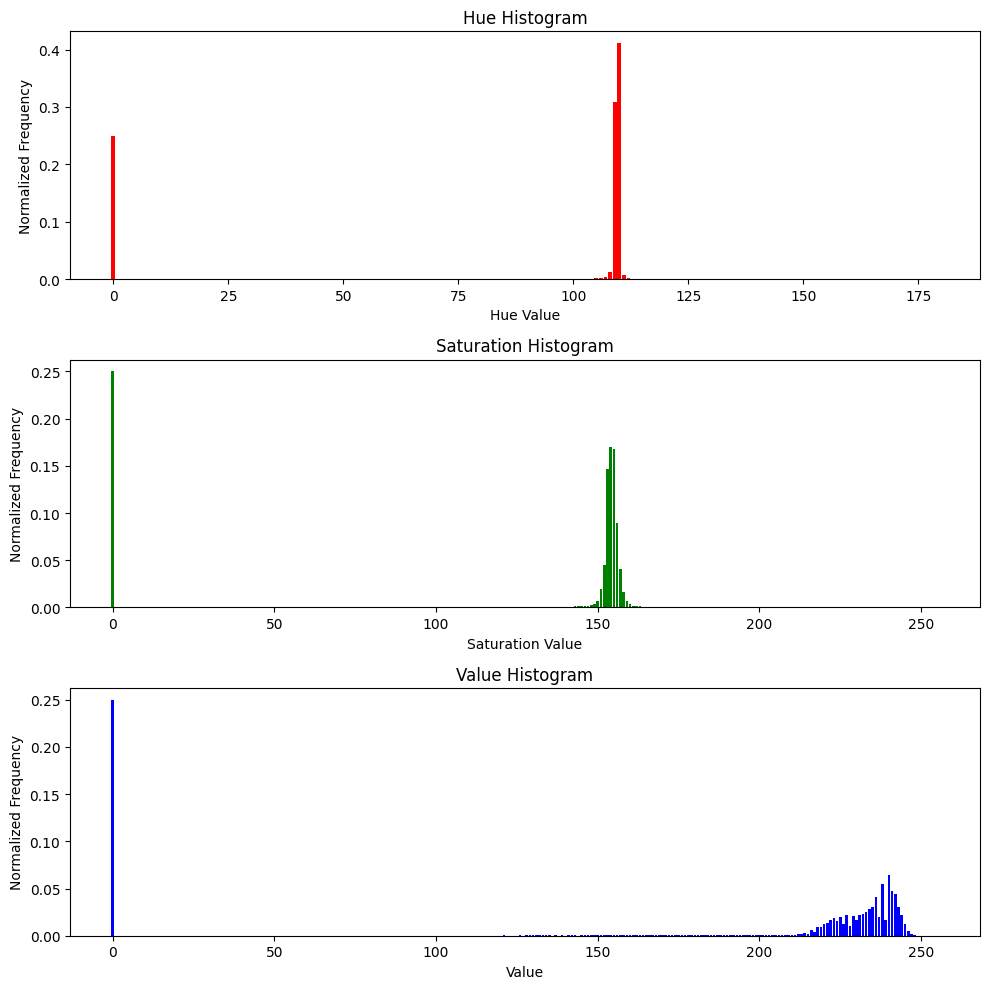

In [3]:
# Plot histogram of all three channels on vertical subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].bar(np.arange(180), hues, color='r')
axs[0].set_title('Hue Histogram')
axs[0].set_xlabel('Hue Value')
axs[0].set_ylabel('Normalized Frequency')

axs[1].bar(np.arange(256), saturations, color='g')
axs[1].set_title('Saturation Histogram')
axs[1].set_xlabel('Saturation Value')
axs[1].set_ylabel('Normalized Frequency')

axs[2].bar(np.arange(256), values, color='b')
axs[2].set_title('Value Histogram')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Normalized Frequency')

plt.tight_layout()
plt.show()



# Color Segmentation

In [4]:
# Manually prescribe threshold ranges for hue, saturation, and value based on the histograms
# These values will be used to segment the amphioxus in the video frames
hue_range = [0, 50]
saturation_range = [50, 255]
value_range = [20, 120]

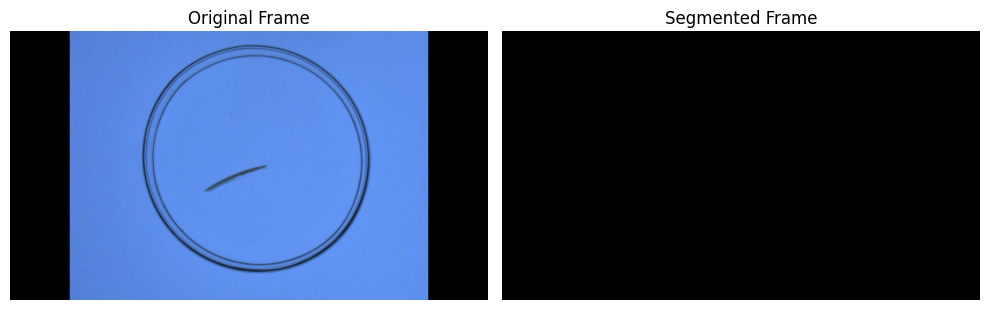

In [5]:
# Load in sample video for processing
cap = cv.VideoCapture(config['CURRENT_DIR'] + "data/HighSpeedTestClip.mp4")

# Show first frame of video with the amphioxus segmented based on the threshold ranges
cap.set(cv.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
if not ret:
    print("Error reading frame")
    exit()

# Convert the frame to the HSV color space
hsv_frame = cv.cvtColor(frame, cv.COLOR_BGR2HSV)

# Create a mask based on the threshold ranges
mask = cv.inRange(hsv_frame, (hue_range[0], saturation_range[0], value_range[0]), (hue_range[1], saturation_range[1], value_range[1]))

# Apply the mask to the original frame
segmented_frame = cv.bitwise_and(frame, frame, mask=mask)

# Display the original frame and the segmented frame in horizontal subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
axs[0].set_title('Original Frame')
axs[0].axis('off')

axs[1].imshow(cv.cvtColor(segmented_frame, cv.COLOR_BGR2RGB))
axs[1].set_title('Segmented Frame')
axs[1].axis('off')

plt.tight_layout()
plt.show()

# Release the video capture object
cap.release()

In [15]:
# Now process entire video into a new video showing original frame and the frame with the segmented amphioxus side by side

# Load in sample video for processing
cap = cv.VideoCapture(config['CURRENT_DIR'] + "data/HighSpeedTestClip.mp4")

# Initialize video writer for mp4
fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter(config['CURRENT_DIR'] + "data/SegmentedVideoDenoised.mp4", fourcc, 30, (2 * int(cap.get(cv.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))))

# Loop through each frame in the video
cap.set(cv.CAP_PROP_POS_FRAMES, 0)
frameNum = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to the HSV color space
    hsv_frame = cv.cvtColor(frame, cv.COLOR_BGR2HSV)

    # Create a mask based on the threshold ranges
    mask = cv.inRange(hsv_frame, (hue_range[0], saturation_range[0], value_range[0]), (hue_range[1], saturation_range[1], value_range[1]))
    
    # Clean up the mask with morphological operations to get rid of noise
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5)))
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5)))

    # Isolate amphioxus by finding the largest connected component in the mask
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(mask)
    largest_label = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1
    mask = np.zeros_like(mask)
    mask[labels == largest_label] = 255

    # Apply the mask to the original frame
    segmented_frame = cv.bitwise_and(frame, frame, mask=mask)

    # Concatenate the original frame and the segmented frame
    combined_frame = np.concatenate((frame, segmented_frame), axis=1)

    # Write the combined frame to the output video
    out.write(combined_frame)

    frameNum += 1

# Release the video writer and capture objects
out.release()
cap.release()
cv.destroyAllWindows()


In [16]:
# Repeat the above but only saving the mask to a video
# Load in sample video for processing
cap = cv.VideoCapture(config['CURRENT_DIR'] + "data/HighSpeedTestClip.mp4")

# Initialize video writer for mp4
fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter(config['CURRENT_DIR'] + "data/maskVideo.mp4", fourcc, 30, (int(cap.get(cv.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))))
                                          
# Loop through each frame in the video
cap.set(cv.CAP_PROP_POS_FRAMES, 0)
frameNum = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to the HSV color space
    hsv_frame = cv.cvtColor(frame, cv.COLOR_BGR2HSV)

    # Create a mask based on the threshold ranges
    mask = cv.inRange(hsv_frame, (hue_range[0], saturation_range[0], value_range[0]), (hue_range[1], saturation_range[1], value_range[1]))
    
    # Clean up the mask with morphological operations to get rid of noise
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5)))
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5)))

    # Isolate amphioxus by finding the largest connected component in the mask
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(mask)
    largest_label = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1
    mask = np.zeros_like(mask)
    mask[labels == largest_label] = 255

    # Convert the mask to a 3-channel image
    mask = cv.cvtColor(mask, cv.COLOR_GRAY2RGB)

    # Write the mask to the output video
    out.write(mask)

    frameNum += 1

# Release the video writer and capture objects
out.release()
cap.release()
cv.destroyAllWindows()


# Kinematic Estimation